# Ageing Score Calculation
## Xiaonan Wang
## 23May2023

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


In [5]:
adata = sc.read('./write/lognorm_edgeR.h5ad')
adata.raw = adata

In [6]:
AL = np.genfromtxt('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Niki/GSE157832/age_gene20.txt', dtype=str)
print(len(AL))
AL = np.intersect1d(AL, adata.raw.var_names)
print(len(AL))

20
17


In [7]:
print(AL)

['Cd38' 'Clca3a1' 'Clec1a' 'Enpp5' 'Fhl1' 'Gpr183' 'Gstm2' 'Itgb3' 'Klhl4'
 'Mt1' 'Neo1' 'Nupr1' 'Plscr2' 'Ptprk' 'Sbspon' 'Selp' 'Vwf']


In [8]:
adata_norm = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, obsm=adata.obsm)

In [9]:
sc.pp.scale(adata_norm)

In [10]:
sc.tl.score_genes(adata_norm, AL)

computing score 'score'
    finished: added
    'score', score of gene set (adata.obs).
    347 total control genes are used. (0:00:00)


In [11]:
adata.obs['AS_score'] = adata_norm.obs['score']

In [18]:
adata.obs['Condition'].cat.categories

Index(['WT', 'Aldh2KO', 'Fancd2KO', 'p53KO', 'DKO', 'TKO'], dtype='object')

In [15]:
adata.uns['Condition_colors']

array(['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b'],
      dtype=object)

Fancd2KO v.s. DKO: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.439e-03 U_stat=4.900e+01
Aldh2KO v.s. DKO: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.104e-04 U_stat=9.800e+01
WT v.s. DKO: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.089e-08 U_stat=5.070e+02


(<AxesSubplot:title={'center':'LTHSC'}, ylabel='AS_score'>,
  <statannot.StatResult.StatResult at 0x2b4fe1ed3730>])

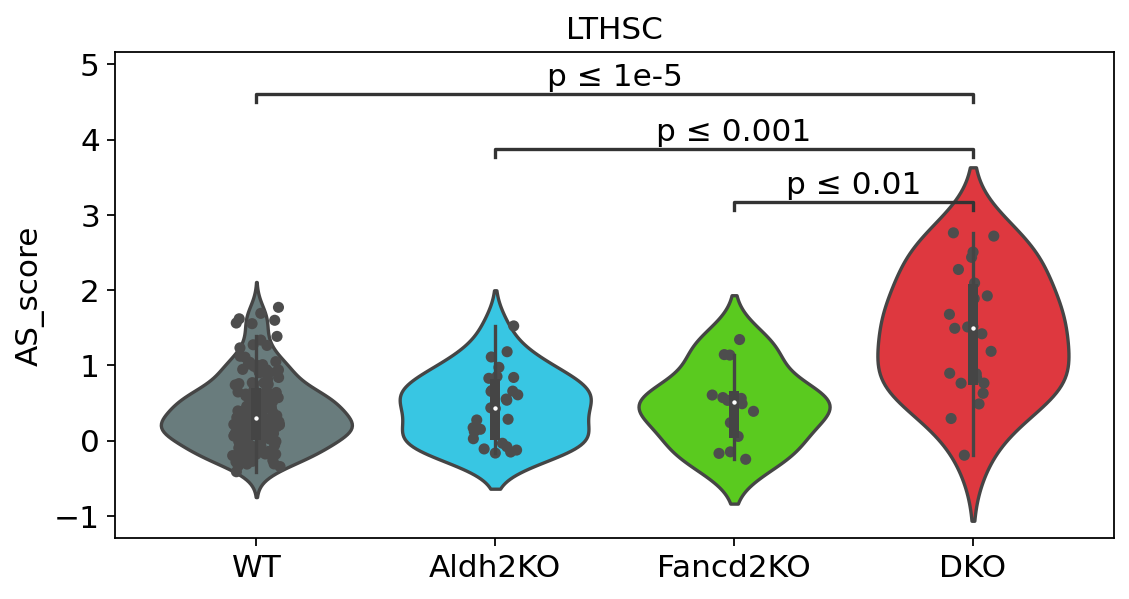

In [20]:
# Figure2B
from statannot import add_stat_annotation
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,4))
df = adata[(adata.obs['Combined_CT'] == 'LTHSC') & (np.in1d(adata.obs['Condition'], ['WT', 'Aldh2KO', 'Fancd2KO', 'DKO']))].obs[['AS_score', 'Condition']]
sns.violinplot(x='Condition', y='AS_score', data=df,  scale='width', ax=ax, palette=["#657F81", "#1CD9FF", "#51E603", "#FA1C26"])
sns.stripplot(x="Condition", y="AS_score", data=df, jitter=True, zorder=1, color=".3")
ax.grid(False)
ax.set_xlabel('')
ax.set_title('LTHSC')
add_stat_annotation(ax, data=df, x='Condition', y='AS_score',
                        box_pairs=[ ('WT', 'DKO'), ('Aldh2KO', 'DKO'), ('Fancd2KO', 'DKO')],
                        test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)


p53KO v.s. DKO: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.343e-08 U_stat=1.660e+02
WT v.s. p53KO: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.445e-02 U_stat=6.954e+03
DKO v.s. TKO: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.985e-05 U_stat=6.490e+02
WT v.s. TKO: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.834e+03


(<AxesSubplot:title={'center':'LTHSC'}, ylabel='AS_score'>,
  <statannot.StatResult.StatResult at 0x2b4fdec1b490>])

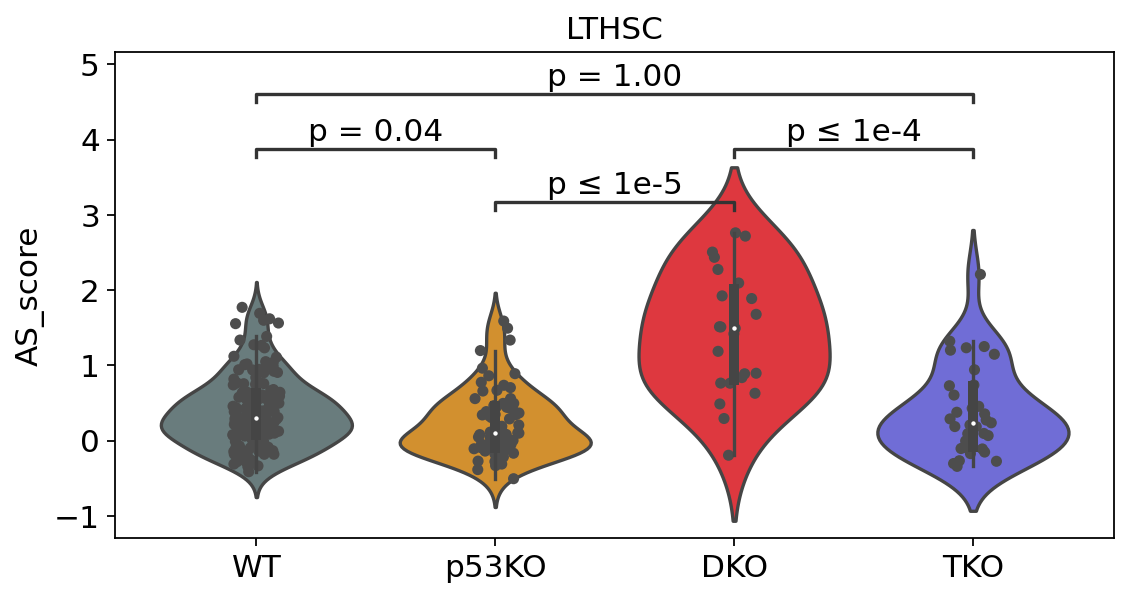

In [22]:
# Figure4B
fig, ax = plt.subplots(figsize=(8,4))
df = adata[(adata.obs['Combined_CT'] == 'LTHSC') & (np.in1d(adata.obs['Condition'], ['WT', 'p53KO', 'DKO', 'TKO']))].obs[['AS_score', 'Condition']]
sns.violinplot(x='Condition', y='AS_score', data=df,  scale='width', ax=ax, palette=["#657F81", "#ED9514","#FA1C26", "#605BE8"])
sns.stripplot(x="Condition", y="AS_score", data=df, jitter=True, zorder=1, color=".3")
ax.grid(False)
ax.set_xlabel('')
ax.set_title('LTHSC')
add_stat_annotation(ax, data=df, x='Condition', y='AS_score',
                        box_pairs=[ ('WT', 'TKO'), ('p53KO', 'DKO'), ('WT', 'p53KO'), ('DKO', 'TKO')],
                        test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)
